# ASTR 596: FDS Homework 7: Gaussian Processes


### Last week, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
#tab

In [2]:
#tab[tab['quarter']==6]['time']

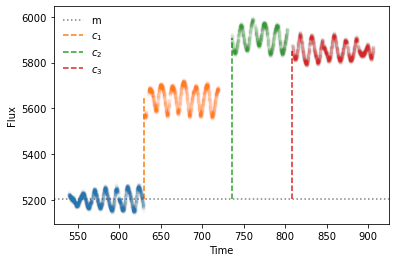

In [3]:
qs = sorted(np.unique(tab['quarter']))
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False)


In [4]:
means

[5203.7993840014005, 5643.826820751147, 5906.00942404101, 5852.1877312730585]

In [5]:
idx1 = cycle_map[6]
idx2 = cycle_map[7]
idx3 = cycle_map[8]
idx4 = cycle_map[9]

In [6]:
#plt.plot(tab[idx1]['time'],tab[idx1]['flux'])
#plt.plot(tab[idx2]['time'],tab[idx2]['flux'])
#plt.plot(tab[idx3]['time'],tab[idx3]['flux'])
#plt.plot(tab[idx4]['time'],tab[idx4]['flux'])

        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]
        Use astropy.stats.LombScargle instead. [astroML.time_series.ACF]


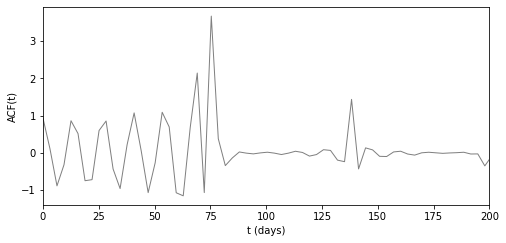

In [7]:
from astroML.time_series import ACF_scargle, ACF_EK

C_S, t_S = ACF_scargle(tab[idx1]['time'], tab[idx1]['flux'], tab[idx1]['error'], 
                       n_omega=2 ** 12,omega_max=1)

#C_EK, C_EK_err, bins = ACF_EK(tab[idx1]['time'], tab[idx1]['flux'], tab[idx1]['error'])
#t_EK = 0.5 * (bins[1:] + bins[:-1])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(212)
ax.set_xlim(0,200)
#ax.set_ylim(-0.1, 0.1)
ax.plot(t_S, C_S, '-', c='gray', lw=1)
#ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')
plt.show()

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations.

In [7]:
#from sklearn.gaussian_process import GaussianProcessRegressor
import george
from george import kernels
from scipy.optimize import minimize
import scipy.optimize as op
import emcee

In [8]:
def combined_kernel(gamma, P, Lambda, A):
    k1 = kernels.ExpSine2Kernel(gamma=gamma, log_period=P)
    k2 = kernels.ExpSquaredKernel(Lambda)
    kernel = A * (k1 * k2)
    return kernel

### Q2: To implement the full model, read how to use `george`'s modeling protocol:
https://george.readthedocs.io/en/latest/tutorials/model/

In [9]:
def model(kernel, m,c1,c2,c3):
    gp1 = george.GP(kernel = kernel, mean=m, fit_mean=True)
    gp2 = george.GP(kernel = kernel, mean=m+c1, fit_mean=True)
    gp3 = george.GP(kernel = kernel, mean=m+c2, fit_mean=True)
    gp4 = george.GP(kernel = kernel, mean=m+c3, fit_mean=True)
    
    return gp1, gp2, gp3, gp4

In [10]:
#negative log likelihood without prior
def nll(p):
    """
    p[0] = m
    p[1] = gamma
    p[2] = P
    p[3] = Lambda
    p[4] = A
    p[5] = m + c1
    p[6] = m + c2
    p[7] = m + c3
    
    """
    gp1.set_parameter_vector(p[0:5])
    gp2.set_parameter_vector(np.append(p[5],p[1:5]))
    gp3.set_parameter_vector(np.append(p[6],p[1:5]))
    gp4.set_parameter_vector(np.append(p[7],p[1:5]))
    ll1 = gp1.log_likelihood(tab[idx1]['flux'][::10], quiet=True)
    ll2 = gp2.log_likelihood(tab[idx2]['flux'][::10], quiet=True)
    ll3 = gp3.log_likelihood(tab[idx3]['flux'][::10], quiet=True)
    ll4 = gp4.log_likelihood(tab[idx4]['flux'][::10], quiet=True)
    ll = ll1 + ll2 + ll3 +ll4
    return -ll if np.isfinite(ll) else 1e25


# NOT using gradient optimization because I am not sure how to combine it for 4 different gps!
# And the gradient of the objective function.
#def grad_nll(p):
#    gp.set_parameter_vector(p)
#    return -gp.grad_log_likelihood(y, quiet=True)

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots)

In [11]:
gamma = 0.1
P = np.log10(40)
Lambda = 100
A = np.log10(10)
m = means[0]
c1 = means[1] - m
c2 = means[2] - m
c3 = means[3] - m

In [12]:
kernel = combined_kernel(gamma, P, Lambda, A)
gp1, gp2, gp3, gp4 = model(kernel,m,c1,c2,c3)

In [13]:
gp1.get_parameter_names()

('mean:value',
 'kernel:k1:log_constant',
 'kernel:k2:k1:gamma',
 'kernel:k2:k1:log_period',
 'kernel:k2:k2:metric:log_M_0_0')

In [14]:
p10 = gp1.get_parameter_vector()
p20 = gp2.get_parameter_vector()
p30 = gp3.get_parameter_vector()
p40 = gp4.get_parameter_vector()


p0 = np.append(p10,[p20[0],p30[0],p40[0]])

gp1.compute(tab[idx1]['time'][::10])
gp2.compute(tab[idx2]['time'][::10])
gp3.compute(tab[idx3]['time'][::10])
gp4.compute(tab[idx4]['time'][::10])

#results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
results = op.minimize(nll, p0)

In [15]:
#best parameters
print('Best results from GP')
print(results.x)

Best results from GP
[5.20379938e+03 1.82607382e-05 1.00017538e-01 1.60207050e+00
 4.60515958e+00 5.64382682e+03 5.90600942e+03 5.85218773e+03]


In [16]:
#update gp with the best parameters
gp1.set_parameter_vector(results.x[0:5])
gp2.set_parameter_vector(np.append(results.x[5],results.x[1:5]))
gp3.set_parameter_vector(np.append(results.x[6],results.x[1:5]))
gp4.set_parameter_vector(np.append(results.x[7],results.x[1:5]))

In [18]:
#gp1.get_parameter_dict()

/Users/sreevani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Users/sreevani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/sreevani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


Text(0.5, 1.0, 'GP prediction using every 10 data points')

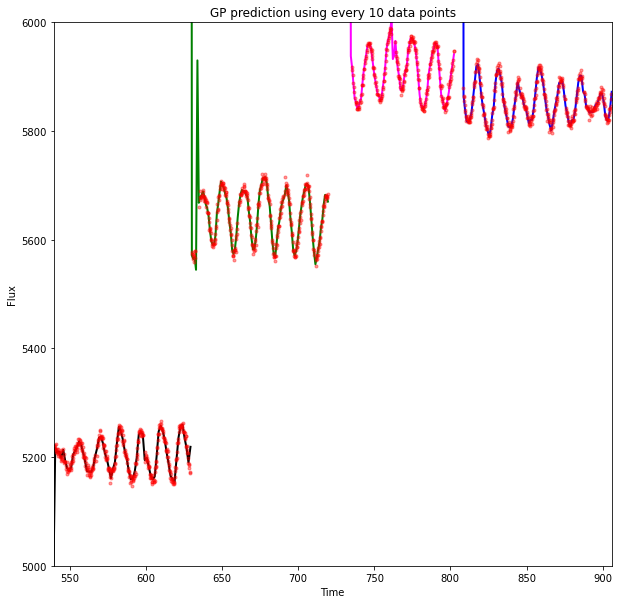

In [18]:
#plot gp 

x1 = np.linspace(500, max(tab[idx1]['time']), 100)
x2 = np.linspace(max(tab[idx1]['time']), max(tab[idx2]['time']), 100)
x3 = np.linspace(max(tab[idx2]['time']), max(tab[idx3]['time']), 100)
x4 = np.linspace(max(tab[idx3]['time']), max(tab[idx4]['time']), 100)


mu1, var1 = gp1.predict(tab[idx1]['flux'][::10],x1, return_var=True)
std1 = np.sqrt(var1)
mu2, var2 = gp2.predict(tab[idx2]['flux'][::10],x2, return_var=True)
std2 = np.sqrt(var2)
mu3, var3 = gp3.predict(tab[idx3]['flux'][::10],x3, return_var=True)
std3 = np.sqrt(var3)
mu4, var4 = gp4.predict(tab[idx4]['flux'][::10],x4, return_var=True)
std4 = np.sqrt(var4)

fig = plt.figure(figsize=(10,10))

#plotting every 100 points for clarity
#plt.errorbar(tab['time'][::5], tab['flux'][::5], yerr= tab['error'][::5], fmt=".k",capsize=0)

plt.errorbar(tab[idx1]['time'][::10],tab[idx1]['flux'][::10],fmt=".r",capsize=0,alpha=0.4)
plt.plot(x1, mu1, "k", lw=2)
plt.fill_between(x1, mu1+std1, mu1-std1,  alpha=0.5)

#plt.plot(x2, mu2-mu1, "g", lw=1.5, alpha=0.5)
#plt.fill_between(x2, (mu2-mu1)+std2, (mu2-mu1)-std2,  alpha=0.5)
plt.errorbar(tab[idx2]['time'][::10],tab[idx2]['flux'][::10],fmt=".r",capsize=0,alpha=0.4)
plt.plot(x2, mu2, "g", lw=2)
plt.fill_between(x2, (mu2)+std2, (mu2)-std2,  alpha=0.5)

plt.errorbar(tab[idx3]['time'][::10],tab[idx3]['flux'][::10],fmt=".r",capsize=0,alpha=0.4)
plt.plot(x3, mu3, "magenta", lw=2)
plt.fill_between(x3, mu3+std3, mu3-std3,  alpha=0.5)

plt.errorbar(tab[idx4]['time'][::10],tab[idx4]['flux'][::10],fmt=".r",capsize=0,alpha=0.4)
plt.plot(x4, mu4, "b", lw=2)
plt.fill_between(x4, mu4+std4, mu4-std4,  alpha=0.5)


plt.xlim(np.min(tab[idx1]['time']), np.max(tab[idx4]['time']))
plt.ylim(5000,6000)
plt.xlabel('Time')
plt.ylabel('Flux')

plt.title('GP prediction using every 10 data points')

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help

In [19]:
#define prior for emcee and combine it with negative loglike of gp
def lnprior(p):
    if 5100. < p[0] < 5300. and -100. < p[1] < 1000 and 0. < p[2] < 1000 and \
    -100. < p[3] < 1000 and -100. < p[4] < 1000 and 5600. < p[5] < 5800. and 5800. < p[6] < 6000. \
    and 5800. < p[7] < 6000.:
        return 0.0
    else:
        return -np.inf
    
def neg_loglike(p):
    gp1.set_parameter_vector(p[0:5])
    gp2.set_parameter_vector(np.append(p[5],p[1:5]))
    gp3.set_parameter_vector(np.append(p[6],p[1:5]))
    gp4.set_parameter_vector(np.append(p[7],p[1:5]))
    return lnprior(p) + nll(p)


In [20]:
#compute gp 
gp1.compute(tab[idx1]['time'][::10])
gp2.compute(tab[idx2]['time'][::10])
gp3.compute(tab[idx3]['time'][::10])
gp4.compute(tab[idx4]['time'][::10])

p10 = gp1.get_parameter_vector()
p20 = gp2.get_parameter_vector()
p30 = gp3.get_parameter_vector()
p40 = gp4.get_parameter_vector()
p0 = np.append(p10,[p20[0],p30[0],p40[0]])

nwalkers, ndim = 50, 8
nsteps = 200
nburn = 10

pos = p0 + np.random.normal(0.0, 2,(nwalkers,ndim))
#pos =results.x + np.random.normal(0.0, 1.5,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, neg_loglike)
_ = sampler.run_mcmc(pos, nsteps,rstate0=np.random.get_state())


/Users/sreevani/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


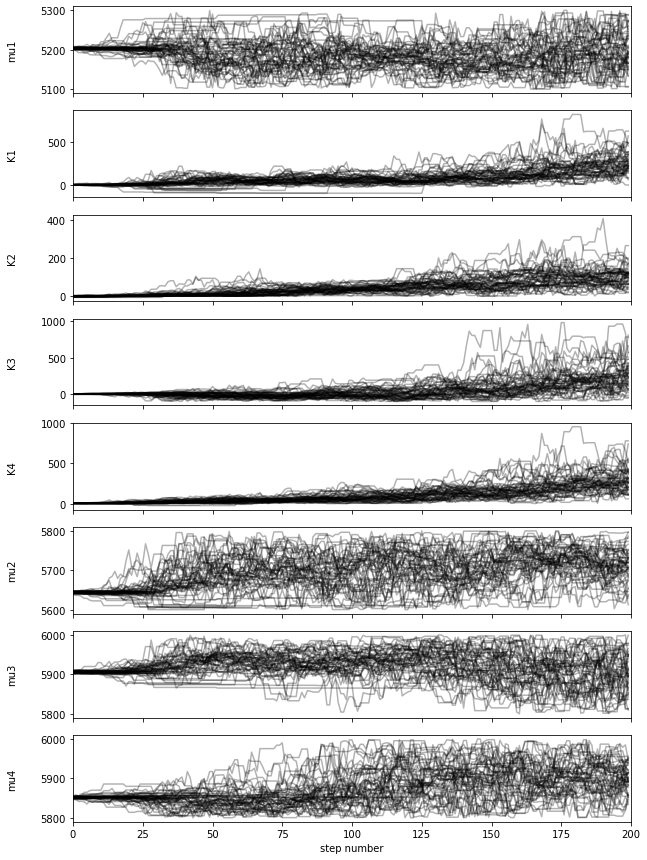

In [21]:
fig, axes = plt.subplots(ndim, figsize=(10, 15), sharex=True)
samples = sampler.get_chain()

labels = ["mu1", "K1","K2","K3","K4","mu2","mu3","mu4"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0,len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [22]:
flat_samples = sampler.get_chain(flat=True)

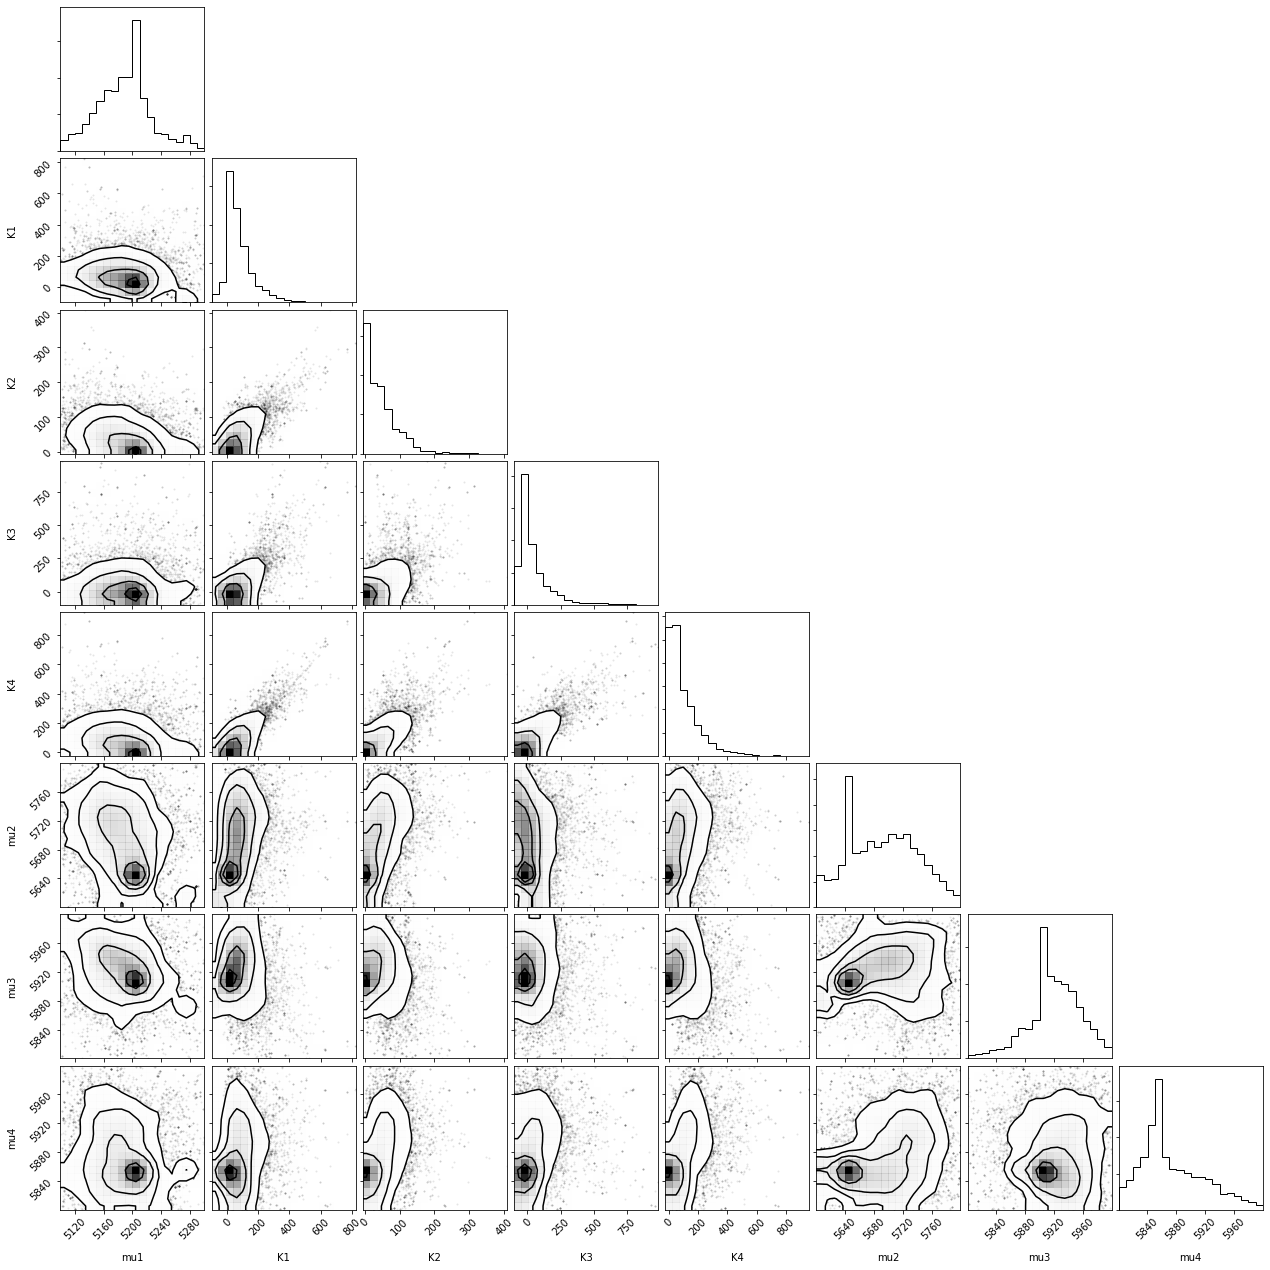

In [23]:
import corner

fig = corner.corner(
    flat_samples, labels=labels,smooth=True);

In [24]:
best_fit_mcmc = []
err_best_fit_mcmc = []
for i in range(ndim):
    best_fit_mcmc.append(np.mean(samples[:, :, i]))
    err_best_fit_mcmc.append(np.std(samples[:, :, i]))
best_fit_mcmc = np.array(best_fit_mcmc)
err_best_fit_mcmc = np.array(err_best_fit_mcmc)

In [25]:
print('The best fit values from MCMC')
print(best_fit_mcmc)

The best fit values from MCMC
[5188.83604929   78.25489643   45.53093276   49.50332644  100.61468398
 5691.94241412 5919.93823908 5873.96132027]


### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black. 

In [26]:
gp1.set_parameter_vector(best_fit_mcmc[0:5])
gp2.set_parameter_vector(np.append(best_fit_mcmc[5],best_fit_mcmc[1:5]))
gp3.set_parameter_vector(np.append(best_fit_mcmc[6],best_fit_mcmc[1:5]))
gp4.set_parameter_vector(np.append(best_fit_mcmc[7],best_fit_mcmc[1:5]))

In [27]:
x1 = np.linspace(500, max(tab[idx1]['time']), 500)
x2 = np.linspace(max(tab[idx1]['time']), max(tab[idx2]['time']), 500)
x3 = np.linspace(max(tab[idx2]['time']), max(tab[idx3]['time']), 500)
x4 = np.linspace(max(tab[idx3]['time']), max(tab[idx4]['time']), 500)


plt.plot(x1, gp1.sample_conditional(tab[idx1]['flux'][::10], x1), "k", alpha=0.1)
plt.plot(x2, gp2.sample_conditional(tab[idx2]['flux'][::10], x2), "g", alpha=0.1)
plt.plot(x3, gp3.sample_conditional(tab[idx3]['flux'][::10], x3), "magenta", alpha=0.1)
plt.plot(x4, gp4.sample_conditional(tab[idx4]['flux'][::10], x4), "b", alpha=0.1)


plt.title('GP prediction using MCMC bestfits')

plt.xlim(np.min(tab[idx1]['time']), np.max(tab[idx4]['time']))
plt.ylim(5000,6000)

LinAlgError: 2-th leading minor of the array is not positive definite